# Rock-Paper-Sciccors Game

## Multi-class Classifier

### Imports

In [0]:
import os
import gc
import tqdm

import cv2
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [2]:
data_path = '../DATA/rockpaperscissors/'

# Load rock imgs
rock_imgs = [data_path+'rock/{}'.format(i) for i in os.listdir(data_path+'rock/')]
# Load paper imgs
paper_imgs = [data_path+'paper/{}'.format(i) for i in os.listdir(data_path+'paper/')]
# Load scissors imgs
scissors_imgs = [data_path+'scissors/{}'.format(i) for i in os.listdir(data_path+'scissors/')]

# All images
all_images = rock_imgs + paper_imgs + scissors_imgs

np.random.seed(42)
np.random.shuffle(all_images)

print("Rock:     ", len(rock_imgs),
      "\nPaper:    ", len(paper_imgs),
      "\nScissors: ", len(scissors_imgs))
print("Total:\t ", len(all_images))

Rock:      726 
Paper:     712 
Scissors:  750
Total:	  2188


In [3]:
# Memory cleaning
del rock_imgs, paper_imgs, scissors_imgs
gc.collect()

19

#### View Data

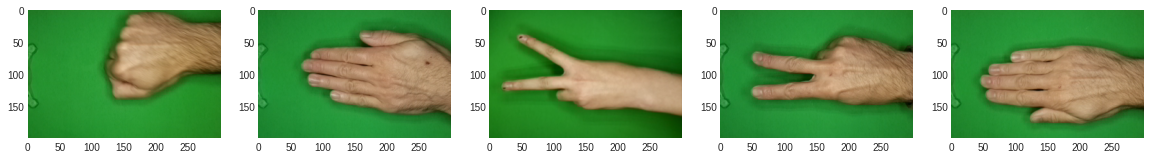

In [4]:
plt.style.use(['seaborn-dark'])

examples = 5
plt.figure(figsize=(20,10))
for i in range(examples):
    image = mpimg.imread(all_images[i])
    plt.subplot(examples / examples + 1, examples, i + 1)
    plt.imshow(image)

#### Processing Data

In [0]:
import time
from tqdm import tqdm

# Function for load and process images
def read_and_process_images(imgs, new_height, new_width):
    X = [] # images
    y = [] # labels

    for image in tqdm(imgs):
        # Load image
        img = cv2.cvtColor(cv2.imread(image, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        # Resize the image and add it to the dataset
        X.append(cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC))
        # Labels
        if 'rock_' in image:
            y.append(0)
        elif 'paper_' in image:
            y.append(1)
        elif 'scissors_' in image:
            y.append(2)
        
    return X, y

#### Create Dataset

In [6]:
n_rows = 100 # new height
n_columns = 150 # new width
channels = 3

X, y = read_and_process_images(all_images, n_rows, n_columns)

X = np.array(X)
y = np.array(y)

100%|██████████| 2188/2188 [00:04<00:00, 536.48it/s]


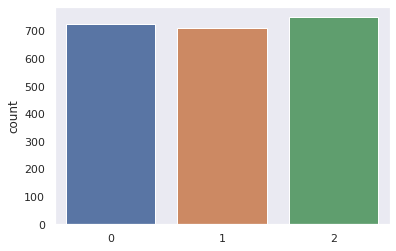

In [7]:
# Check labels
sns.set(style="dark")
ax = sns.countplot(y)

In [8]:
# Memory cleaning
del all_images
gc.collect()

10179

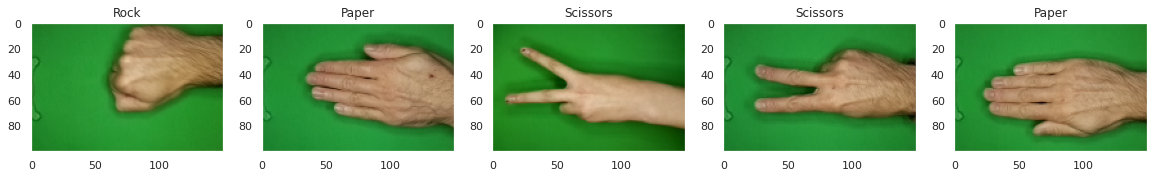

In [9]:
# check some images
class_names = ['Rock', 'Paper', 'Scissors']

examples = 5
plt.figure(figsize=(20,10))
for i in range(examples):
    plt.subplot(examples / examples + 1, examples, i + 1)
    plt.title(class_names[y[i]], fontsize=12)
    plt.imshow(X[i])

### Split Dataset

#### Train Set and Test Set

In [10]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print("85% - X_full size:", X_train_full.shape, " y_full size:", y_train_full.shape)
print("15% - X_test size: ", X_test.shape, " y_test size: ", y_test.shape)

85% - X_full size: (1859, 100, 150, 3)  y_full size: (1859,)
15% - X_test size:  (329, 100, 150, 3)  y_test size:  (329,)


#### Validation Set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42)

print("85% - X_train size:", X_train.shape, " y_train size:", y_train.shape)
print("15% - X_test size:  ", X_val.shape, " y_test size:  ", y_val.shape)

85% - X_train size: (1580, 100, 150, 3)  y_train size: (1580,)
15% - X_test size:   (279, 100, 150, 3)  y_test size:   (279,)


In [12]:
# Memory cleaning
del X_train_full, y_train_full
gc.collect()

9630

### ConvNet

#### Settings

In [0]:
n_train = len(X_train)
n_val = len(X_val)
batch_size = 32

#### Model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [0]:
tf.random.set_seed(42)

In [0]:
from functools import partial

DefaultConv2D = partial(Conv2D,
                        kernel_size=3,
                        activation='relu',
                        padding='SAME')

In [17]:
model = Sequential([
    DefaultConv2D(filters=32, kernel_size=7, input_shape=[n_rows,n_columns,channels]),
    MaxPooling2D(pool_size = 2),
    DefaultConv2D(filters = 64),
    MaxPooling2D(pool_size = 2),
    DefaultConv2D(filters = 128),
    Flatten(),
    # fully connected network
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    Dense(units = 3, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 150, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 37, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 118400)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

##### Compile the Model

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

#### Prepare Data for Training

##### Scaling and Data Augmentation

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

print(X_train.shape)

(1580, 100, 150, 3)


#### Callbacks

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model each time
path = '../SavedModels/'
checkpoint_cb = ModelCheckpoint(path + 'best_model.h5',
                                save_best_only=True)

# Early stopping
early_stopping_cb = EarlyStopping(patience=5,
                                  restore_best_weights=True)

#### Training

In [22]:
history = model.fit(train_generator,
                    steps_per_epoch=n_train // batch_size,
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=n_val // batch_size,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
49/49 [==============================] - 6s 122ms/step - loss: 1.0840 - accuracy: 0.4005 - val_loss: 0.9897 - val_accuracy: 0.4414
Epoch 2/100
49/49 [==============================] - 6s 117ms/step - loss: 0.7957 - accuracy: 0.6583 - val_loss: 0.4927 - val_accuracy: 0.8203
Epoch 3/100
49/49 [==============================] - 6s 117ms/step - loss: 0.6245 - accuracy: 0.7397 - val_loss: 0.3910 - val_accuracy: 0.8672
Epoch 4/100
49/49 [==============================] - 5s 111ms/step - loss: 0.5915 - accuracy: 0.7532 - val_loss: 0.4463 - val_accuracy: 0.8555
Epoch 5/100
49/49 [==============================] - 6s 117ms/step - loss: 0.4787 - accuracy: 0.8185 - val_loss: 0.3164 - val_accuracy: 0.9023
Epoch 6/100
49/49 [==============================] - 6s 119ms/step - loss: 0.4715 - accuracy: 0.8224 - val_loss: 0.3151 - val_accuracy: 0.8633
Epoch 7/100
49/49 [==============================] - 6s 117ms/step - loss: 0.3738 - accuracy: 0.8482 - val_loss: 0.2413 - val_accuracy: 0.8867

#### Learning curves

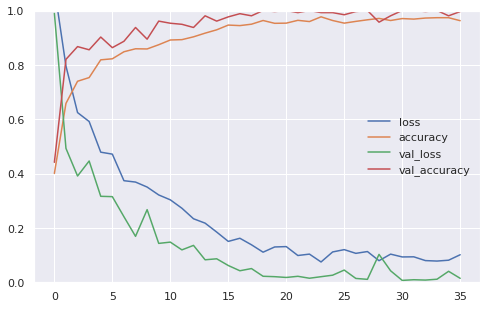

In [23]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

### Evaluate Model on Test Set

In [24]:
X_test = X_test / 255.
X_test = np.array(X_test)

print(X_test.shape)

(329, 100, 150, 3)


In [25]:
eval_loss, eval_acc = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 16ms/step - loss: 0.0249 - accuracy: 0.9939


#### Make Some Predictions

In [0]:
X_new = X_test[:5]

In [27]:
y_proba = model.predict(X_new)

print(y_proba.round(3))

[[0.045 0.954 0.   ]
 [1.    0.    0.   ]
 [0.    0.001 0.999]
 [0.    1.    0.   ]
 [0.    0.    1.   ]]


In [28]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
print(y_pred)

[1 0 2 1 2]


In [29]:
# Check if predictions are correct
print(y_test[:5])

[1 0 2 1 2]


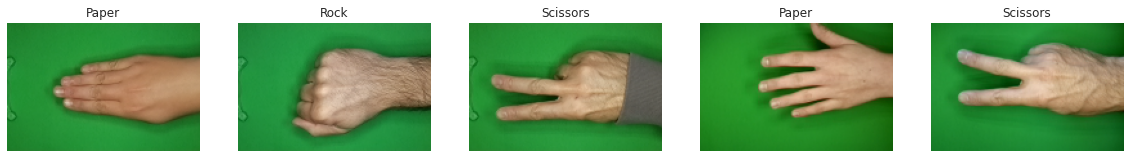

In [30]:
class_names = ['Rock', 'Paper', 'Scissors']

plt.figure(figsize=(20,10))
for index, image in enumerate(X_new):
    plt.subplot(1, len(X_new), index + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(class_names[y_pred[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()